#### package

In [1]:
from typing import Optional, Callable, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba import Mamba, MambaConfig
from loss_functions import get_loss_fn
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from sklearn.preprocessing import PowerTransformer
from dataclasses import dataclass
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
import gc

/home/luchinwei/anaconda3/envs/mambastock/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### hyperparameters

In [2]:
save_dir = '0730_2330/'
use_cuda = True
n_steps=15
window=60
patience = 100
val_ratio = 0.2
epochs = 1000
loss_fcn = "mse"

lr = 0.0005
wd = 1e-5
hidden = 32
layer = 3
n_test = 350
ts_code = 2330
risk_free = 0.017

In [3]:
def generate_return_features(data, price_col='close', windows=[5, 10, 20]):
    import pandas as pd

    df = data.copy()
    returns = df[price_col].pct_change()

    # 基本報酬率
    df['returns'] = returns

    for window in windows:
        # 移動平均報酬率
        df[f'returns_ma_{window}'] = returns.rolling(window=window).mean()
        
        # 指數移動平均
        df[f'returns_ema_{window}'] = returns.ewm(span=window, adjust=False).mean()

        # 報酬率波動度
        df[f'returns_volatility_{window}'] = returns.rolling(window=window).std()

        # 報酬率的 Z-score
        mean = returns.rolling(window=window).mean()
        std = returns.rolling(window=window).std()
        df[f'returns_zscore_{window}'] = (returns - mean) / std

    return df.dropna()


#### Import Data

In [4]:
data = pd.read_csv(str(ts_code)+"_value"+'.csv')
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y/%m/%d')

# 加入星期幾（0=星期一, 6=星期日）
data['day_of_week'] = data['trade_date'].dt.dayofweek

# 加入月份（1～12）
data['month'] = data['trade_date'].dt.month

returns = data['close_TW_roc'] 

tp=[5, 10, 20]

for tp in tp:
    # 移動平均報酬率
    data[f'returns_ma_{tp}'] = returns.rolling(window=tp).mean()
    
    # 指數移動平均
    data[f'returns_ema_{tp}'] = returns.ewm(span=tp, adjust=False).mean()

    # 報酬率波動度
    data[f'returns_volatility_{tp}'] = returns.rolling(window=tp).std()

    # 報酬率的 Z-score
    mean = returns.rolling(window=tp).mean()
    std = returns.rolling(window=tp).std()
    data[f'returns_zscore_{tp}'] = (returns - mean) / std

data = data.dropna().reset_index(drop=True)

'''
['trade_date', 'stock_no', 'stock_name', 'stock_type', 
'open_TW', 'close_TW', close_TW_roc, 'h_TW', 'l_TW', 'vol_TW', 'CBOE_SKEW_INDEX', 
'CBOE_Volatility_INDEX', 'COPPER_F', 'COPPER', 'GOLD_F', 
'GOLD', 'OIL_F', 'OIL', 'SP_F', 'SILVER_F', 'SILVER', 
'TWII', 'IXIC', 'GSPC', 'DJI', 'NYSE', 'RUSSELL', 'SSE', 
'FCHI', 'FTSE', 'GDAXI', 'Nikkei_F', 'IXIC_F', 'DJI_F', 
'S_P_F', 'USDX_F', 'JPY', 'GBP', 'HKD', 'CNY', 'AUD', 
'TWD', 'EUR', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS1', 
'DAAA', 'DBAA', 'DGS3MO', 'DGS6MO', 'DGS1.1', 'DCOILWTICO', 
'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 
'DE6', 'DCOILWTICO_rel_change', 'day_of_week', 'month']
'''

index = ['open_TW', 'close_TW', 'h_TW', 'l_TW', 'vol_TW', 'CBOE_SKEW_INDEX', 
'CBOE_Volatility_INDEX', 'TWII', 'DJI', 'NYSE', 'TWD', 'CNY',
'GOLD', 'OIL', 'SILVER', 'FCHI', 'TE5', 'DE4',
'day_of_week', 'month',
"returns_ma_5", "returns_ema_5", "returns_volatility_5","returns_zscore_5",
"returns_ma_10", "returns_ema_10", "returns_volatility_10", "returns_zscore_10",
"returns_ma_20", "returns_ema_20", "returns_volatility_20", "returns_zscore_20"]

# 拆離 label 欄位

ratechg = data['close_TW_roc'].values *100

features = data[index].values
num_samples = features.shape[0]
# num_samples: 2520

# 定義 horizon 數
horizon = n_steps

X_list, y_list = [], []
for i in range(num_samples - window - horizon + 1):
    X_win = features[i : i + window]                        # shape: [window, features]
    t = np.arange(window).reshape(-1, 1)  # shape: [window, 1]
    sin_t = np.sin(t / 10000)
    cos_t = np.cos(t / 10000)
    time_encoding = np.concatenate([sin_t, cos_t], axis=1)    # shape: [window, 2]

    X_win = np.concatenate([X_win, time_encoding], axis=1) 
    y_future = ratechg[i + window : i + window + horizon]     # shape: [horizon]
    X_list.append(X_win)
    y_list.append(y_future)

trainX = np.array(X_list[:-n_test])
trainy = np.array(y_list[:-n_test])
testX = np.array(X_list[-n_test:])
testy = np.array(y_list[-n_test:])

# trainX.shape: (2146, 15, 61)  2146 = num_samples - window - horizon + 1
# trainy.shape: (2146, 10)
# testX.shape: (350, 15, 61)
# testy.shape: (350, 10)

#### train / val

In [5]:
val_size = int(len(trainX) * val_ratio)

valX = trainX[-val_size:]
valy = trainy[-val_size:]

trainX = trainX[:-val_size]
trainy = trainy[:-val_size]

# trainX.shape: (1717, 15, 61)
# trainy.shape: (1717, 10)
# valX.shape: (429, 15, 61)
# valy.shape: (429, 10)

in_dim = trainX.shape[2]

#### DataLoader

In [6]:
trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
trainy_tensor = torch.tensor(trainy, dtype=torch.float32)

valX_tensor = torch.tensor(valX, dtype=torch.float32)
valy_tensor = torch.tensor(valy, dtype=torch.float32)

testX_tensor = torch.tensor(testX, dtype=torch.float32)
testy_tensor = torch.tensor(testy, dtype=torch.float32)

# Build datasets and loaders
train_dataset = TensorDataset(trainX_tensor, trainy_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(valX_tensor, valy_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TensorDataset(testX_tensor, testy_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### 模型

In [7]:
class Net(nn.Module):
    """
    多層 Mamba 時序模型，用於序列輸入特徵的未來預測。

    參數:
        in_dim (int): features 數量
        horizon (int): 模型預測的未來時間步數（輸出維度）。
        hidden (int): 中間表示層（latent layer）的維度。
        layer (int): Mamba block 的堆疊層數。

    屬性:
        config (MambaConfig): 用於初始化 Mamba 模型的配置。
        proj_in (nn.Linear): 將輸入特徵從 in_dim 投影到 hidden 維度。
        mamba (Mamba): 多層 Mamba 模型，用於處理時間序列資料。
        pool (nn.AdaptiveAvgPool1d): 算平均
        head (nn.Linear): 轉換為 horizon 維度的預測向量。
    """
    in_dim: int
    horizon: int
    hidden: int
    layer: int

    config: MambaConfig
    proj_in: nn.Linear
    mamba: Mamba
    pool: nn.AdaptiveAvgPool1d
    head: nn.Linear

    def __init__(self, in_dim: int, horizon: int, hidden: int, layer: int) -> None:
        super().__init__()
        self.in_dim = in_dim
        self.horizon = horizon
        self.hidden = hidden
        self.layer = layer

        self.config = MambaConfig(d_model=hidden, n_layers=layer)
        self.proj_in = nn.Linear(in_dim, hidden)
        self.mamba = Mamba(self.config)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(hidden, horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        x = self.proj_in(x)            # x: [B, window, in_dim] → [B, window, hidden]
        x = self.mamba(x)              #                        → [B, window, hidden]
        x = x.transpose(1, 2)          #                        → [B, hidden, window]
        x = self.pool(x).squeeze(-1)   #                        → [B, hidden]
        return self.head(x)            #                        → [B, horizon]

In [8]:
class MLPNet(nn.Module):
    """
    Fully Connected MLP 模型，用於序列特徵的未來預測。

    每個時間步的特徵會被展平成一個長向量，送進 MLP 層中做預測。

    輸入:
        x: [B, window, in_dim] → 展平 → [B, window * in_dim]

    輸出:
        預測向量 [B, horizon]
    """
    in_dim: int
    horizon: int
    hidden: int
    window: int
    flatten_dim: int
    fc: nn.Sequential
    
    def __init__(self, in_dim: int, horizon: int, hidden: int, window: int) -> None:
        super().__init__()
        self.flatten_dim: int = window * in_dim
        self.fc: nn.Sequential = nn.Sequential(
            nn.Linear(self.flatten_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)  # [B, window * in_dim]
        return self.fc(x)          # → [B, horizon]
    
    
    
class TransformerNet(nn.Module):
    """
    輸入:
        x: [B, window, in_dim]
    輸出:
        [B, horizon]
    """
    in_dim: int
    hidden: int
    window: int
    horizon: int
    nhead: int
    num_layers: int
    dropout: float
    
    def __init__(self, in_dim: int, hidden: int, window: int, horizon: int,
                nhead: int = 4, num_layers: int = 2, dropout: float = 0.1):
        super().__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=in_dim, nhead=nhead,
            dim_feedforward=hidden,
            dropout=dropout,
        )
        self.encoder = nn.TransformerEncoder(
            self.encoder_layer,
            num_layers=num_layers
        )
        self.head = nn.Sequential(
            nn.Flatten(),  # [B, window * in_dim]
            nn.Linear(window * in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(0, 1)  # → [seq_len, batch, in_dim]
        x = self.encoder(x)
        x = x.transpose(0, 1)  # → [batch, seq_len, in_dim] 回來再做 flatten/head  
        out = self.head(x)   
        return out
    
    
class NeuralNet():
    
    def __init__(self, num_nodes, weights_=[], classification=True, auto_encoder=False, penalty=0., learn_rate=0.01):
        self.num_nodes = num_nodes
        self.weights_ = weights_
        self.is_fit = False
        self.classification = classification
        self.auto_encoder = auto_encoder
        if auto_encoder:
            self.classification = False
        self.K = 0
        self.penalty = penalty
        self.learn_rate = learn_rate
        np.seterr(all='warn')
    
    def __str__(self):
        return "Neural Networks("

    def initWeights(self, X, nclass):
        bias = np.ones((X.shape[0],1))
        X = np.hstack((bias,X)) #add constant bias to each observation, X now N by P+1
        sizeX = X.shape[1]
        node_weights_ = np.random.uniform(-0.08,0.08,size=(self.num_nodes, sizeX)) #M+1 by P+1
        output_weights_ = np.random.uniform(-0.08,0.08,size=(nclass, self.num_nodes+1)) #K by M+1
        return X, [node_weights_, output_weights_] #nrows = n_nodes, ncols = sizeX
        
    def sigmoid(self, alpha_, X_):
        v_ = alpha_.dot(X_.T)
        v_[v_ < -300] = -300
        v_[v_ > 300] = 300
        return 1./(1+np.exp(-v_))
        
    def relu(self, alpha_, X_):
        try:
            v_ = alpha_.dot(X_.T)
        except ValueError:
            v_ = X_.dot(alpha_)
            v_ = v_.T
        v_[v_ < -300] = -300
        v_[v_ > 300] = 300
        return np.maximum(v_,np.zeros(v_.shape))
        
    def drelu(self, alpha_, X_):
        try:
            v_ = alpha_.dot(X_.T)
        except ValueError:
            v_ = X_.dot(alpha_)
            v_ = v_.T
        v_[v_ <= 0.] = 0
        v_[v_ > 0.] = 1.
        return v_
        
    def tanh(self, alpha_, X_):
        try:
            v_ = alpha_.dot(X_.T)
        except ValueError:
            v_ = X_.dot(alpha_)
            v_ = v_.T
        v_[v_ < -300] = -300
        v_[v_ > 300] = 300
        return np.tanh(v_)
        
    def dtanh(self, alpha_, X_):
        return 1 - np.multiply(self.tanh(alpha_, X_), self.tanh(alpha_, X_))
        
    def softmax(self, T):
        T[T < -300] = -300
        T[T > 300] = 300
        return (np.exp(T)/np.sum(np.exp(T), axis=0)).T #(K by N) / elementwise(1 by N)
        
    def initNodes(self, X, Y):
        K = self.K
        if self.weights_ == []:
            X, weights = self.initWeights(X, K)
        else:
            weights = self.weights_
            bias = np.ones((X.shape[0],1))
            X = np.hstack((bias,X))
        return X, weights
        
    def backPropagate(self, weights, next_weights, X, Y, rho, old_del_alpha, old_del_beta, _dropout, back_delta=0., fine_tune=False):
        """
        feed forward then back propagate error, update weights
        """
        learn_rate = self.learn_rate
#        beta = 6.
#        sparsity = 0.05
        if _dropout:
            drop = np.random.uniform(0, 1, weights[0].shape[0])
        if self.auto_encoder and not fine_tune:
            sig = self.relu(weights[0], X)
            dsig = self.drelu(weights[0], X)
            if _dropout:
                sig[drop>=0.5,:] = 0.
                dsig[drop>=0.5,:] = 0.
#            avg_sparsity = np.mean(sig, axis=1)
        elif not self.auto_encoder and not fine_tune:
            sig = self.tanh(weights[0], X)
            dsig = self.dtanh(weights[0], X)
            if _dropout:
                sig[drop>=0.5,:] = 0.
                dsig[drop>=0.5,:] = 0.
            
        if not fine_tune:
            bias = np.ones((1,sig.shape[1]))
            sig = np.vstack((bias,sig))
            hidden_out = weights[1].dot(sig)
            if self.classification:
                h = self.softmax(hidden_out)
                forward_error = h - Y
            else:
                h = hidden_out.T
                forward_error = h - Y 
            dRdBeta = sig.dot(forward_error)/forward_error.shape[0] #(M+1 by N)*(N by K) = M+1 by K gradient-force for each neuron

        if fine_tune:
            prop_back = np.multiply(back_delta.dot(next_weights[:,1:]),dsig.T)
            dRdAlpha = prop_back.T.dot(X)/X.shape[0]
        elif not fine_tune and not self.auto_encoder:
            back_error = np.multiply((forward_error.dot(weights[1][:,1:])),(dsig.T)) #((N by K)*(K by M+1))*ewise(N by M+1) = N by M+1
            prop_back = back_error
        elif not fine_tune and self.auto_encoder:
            back_error = np.multiply((forward_error.dot(weights[1][:,1:])),(dsig.T))
            prop_back = 0.
#            back_error = np.multiply((forward_error.dot(weights[1][:,1:])),(dsig.T)) + beta*(-sparsity/avg_sparsity+(1-sparsity)/(1-avg_sparsity))
        if not fine_tune:
            dRdAlpha = (back_error.T).dot(X)/X.shape[0]
            del_beta = rho*old_del_beta - learn_rate*dRdBeta.T
        else:
            del_beta = 0.
        del_alpha = rho*old_del_alpha - learn_rate*dRdAlpha
        
        """Bias weights do not get penalized"""
        if not fine_tune:
            bias1 = np.zeros((weights[1].shape[0], 1))
            weights[1] = weights[1] + del_beta + np.hstack((bias1,self.penalty*weights[1][:,1:])) #M+1 by K
        bias0 = np.zeros((weights[0].shape[0], 1))
        weights[0] = weights[0] + del_alpha + np.hstack((bias0,self.penalty*weights[0][:,1:])) #M+1 by P+1

        return weights, del_alpha, del_beta, prop_back
        
#     def feedForward(self,X,layers):
#         activations = []
#         for i,layer in enumerate(layers):
#             if i == 0:
#                 if layer.auto_encoder:
#                     if layer._dropout:
#                         sig = layer.relu(layer.weights_[0]/2.,X)
#                     else:
#                         sig = layer.relu(layer.weights_[0], X)
# #                    sig = layer.tanh(layer.weights_[0], X)
#                 else:
#                     if layer._dropout:
#                         sig = layer.tanh(layer.weights_[0]/2.,X)
#                     else:
#                         sig = layer.tanh(layer.weights_[0], X)
#             else:
#                 if layer.auto_encoder:
#                     bias = np.ones((1,sig.shape[1]))
#                     sig = np.vstack((bias,sig))
#                     if layer._dropout:
#                         sig = layer.relu(layer.weights_[0]/2., sig.T)
#                     else:
#                         sig = layer.relu(layer.weights_[0], sig.T)
#                 else:
#                     if layer._dropout:
#                         sig = layer.tanh(layer.weights_[0]/2., sig.T)
#                     else:
#                         sig = layer.tanh(layer.weights_[0], sig.T)
#             activations.append(sig.T)
#         return activations

    def feedForward(self, X, layers):
        activations = []
        sig = X
        for i, layer in enumerate(layers):
            # 確保輸入維度與 layer.weights_[0] 的 shape 一致
            expected_input_dim = layer.weights_[0].shape[1]  # = D + 1
            if sig.shape[1] == expected_input_dim - 1:
                bias = np.ones((sig.shape[0], 1))
                sig = np.hstack((bias, sig))  # 補上 bias
            elif sig.shape[1] != expected_input_dim:
                raise ValueError(f"Input dim mismatch at layer {i}: expected {expected_input_dim - 1}, got {sig.shape[1]}")
            # forward
            sig = layer.relu(layer.weights_[0], sig) if layer.auto_encoder else layer.tanh(layer.weights_[0], sig)
            activations.append(sig)
        return activations


            
    def fit(self, X, Y, rho=0., maxiter=300, tol=0.000001, anneal=False, t_0=50, dropout=False, batch=40, SGD=True, layers=[], fine_tune=False):
        self._dropout = dropout      
        grad_alpha, grad_beta = 0., 0.
        layer_alphas = [0. for i in range(len(layers))]
        layer_betas = layer_alphas
        self.is_fit = True
        if self.classification:
        #one-hot encode Y
            try:
                #if already one-hot encoded, pass Y as Y_new
                if Y.shape[1] > 1:
                    Y_new = Y
                    self.K = Y.shape[1]
                #else one-hot encode Y as Y_new
                else:
                    self.K = len(set(Y.flatten()))
                    Y_new = np.zeros((len(Y),self.K))
                    for i,v in enumerate(Y):
                        Y_new[i,v] = 1.
            #if Y.shape[1] null (1D array), one-hot encode it as Y_new
            except IndexError:
                self.K = len(set(Y.flatten())) #ditto
                Y_new = np.zeros((len(Y),self.K))
                for i,v in enumerate(Y):
                    Y_new[i,v] = 1.
        else:
            Y_new = Y
            if not self.auto_encoder:
                self.K = Y.shape[1]
            else:
                self.K = Y.shape[1]
        if layers == []:
            X, w = self.initNodes(X, Y_new)
        else:
            bias = np.ones((X.shape[0],1))
            # X = np.hstack((bias,X)) #add constant bias to each observation, X now N by P+1
            X_ = self.feedForward(X,layers)
            X_[-1], w = self.initNodes(X_[-1], Y_new)

        for i in range(maxiter):
            if anneal and i != 0 and i % t_0 == 0:
                self.learn_rate /= (float(i)/t_0)
            if not SGD:
                if fine_tune and layers != []:
                    X_hidden = self.feedForward(X,layers)
                    bias = np.ones((X_hidden[-1].shape[0],1))
                    X_hidden[-1] = np.hstack((bias,X_hidden[-1]))
                
                    w, grad_alpha, grad_beta, back_error = self.backPropagate(w, 0., X_hidden[-1], Y_new, rho, grad_alpha, grad_beta, dropout, back_delta=0., fine_tune=False)
                    next_weights = w[0]                    
                    for i,layer in enumerate(layers[::-1]):
                        if len(layers)-i-2 >= 0:
                            activations = X_hidden[len(layers)-i-2]
                            bias = np.ones((activations.shape[0], 1))
                            activations = np.hstack((bias,activations))
                        else:
                            activations = X
                        layer.weights_, layer_alphas[i], layer_betas[i], back_error = layer.backPropagate(layer.weights_, next_weights, activations, Y_new, rho, layer_alphas[i], layer_betas[i], dropout, back_delta=back_error, fine_tune=True)                     
                        next_weights = layer.weights_[0]
                elif not fine_tune:
                    if self.auto_encoder:
                        choose = np.random.binomial(1, 0.9, size=X.shape)
                        X_noisy = np.multiply(choose, X)
                    else:
                        X_noisy = X
                    w, grad_alpha, grad_beta, back_error = self.backPropagate(w, 0., X_noisy, Y_new, rho, grad_alpha, grad_beta, dropout, back_delta=0., fine_tune=fine_tune)

            else:
                samples = np.random.choice(range(len(X)),size=batch,replace=False)
                if fine_tune and layers != []:
                    try:
                        X_hidden = self.feedForward(X[samples,:],layers)
                    except TypeError:
                        X_samples = [X[z] for z in samples]
                        X_hidden = self.feedForward(X_samples,layers)
                    bias = np.ones((X_hidden[-1].shape[0],1))
                    X_hidden[-1] = np.hstack((bias,X_hidden[-1]))
                
                    w, grad_alpha, grad_beta, back_error = self.backPropagate(w, 0., X_hidden[-1], Y_new[samples,:], rho, grad_alpha, grad_beta, dropout, back_delta=0., fine_tune=False)
                    next_weights = w[0]                    
                    for i,layer in enumerate(layers[::-1]):
                        if len(layers)-i-2 >= 0:
                            activations = X_hidden[len(layers)-i-2]
                            bias = np.ones((activations.shape[0],1))
                            activations = np.hstack((bias,activations))
                        else:
                            try:
                                activations = X[samples,:]
                            except TypeError:
                                activations = [X[z] for z in samples]
                        layer.weights_, layer_alphas[i], layer_betas[i], back_error = layer.backPropagate(layer.weights_, next_weights, activations, Y_new[samples,:], rho, layer_alphas[i], layer_betas[i], dropout, back_delta=back_error, fine_tune=True)                     
                        next_weights = layer.weights_[0]
                elif not fine_tune:
                    if self.auto_encoder:
                        choose = np.random.binomial(1,0.9,size=X[samples,:].shape)
                        X_noisy = np.multiply(choose, X[samples,:])
                        Y_test = X[samples,:]
                    else:
                        X_noisy = X[samples,:]
                        if self.classification:
                            Y_test = Y_new[samples,:]
                        else:
                            Y_test = Y_new[samples]
                    w, grad_alpha, grad_beta, back_error = self.backPropagate(w, 0., X_noisy, Y_test, rho, grad_alpha, grad_beta, dropout, back_delta=0., fine_tune=fine_tune)
            
        self.weights_ = w
        return layers
            
    def predict(self, X, proba=True, layers=[]):
        if self.is_fit:
            self.predictions = []
            if layers==[]:
                bias = np.ones((X.shape[0],1))
                X = np.hstack((bias,X)) #add constant bias to each observation, X now N by P+1
            if layers == []:
                if self.auto_encoder:
                    if self._dropout:
                        activation = self.relu(self.weights_[0]/2, X)
                    else:
                        activation = self.relu(self.weights_[0], X)
                else:
                    if self._dropout:
                        activation = self.tanh(self.weights_[0]/2., X)
                    else:
                        activation = self.tanh(self.weights_[0], X)
                bias = np.ones((1,activation.shape[1]))
                activation = np.vstack((bias,activation))
                response = self.weights_[1].dot(activation)
            else:
                activation = self.feedForward(X,layers)
                activation = activation[-1]
#            print activation.shape
#            if layers != []:
                bias = np.ones((activation.shape[0],1))
                activation = np.hstack((bias,activation))
                if self._dropout:
                    response = self.tanh(self.weights_[0]/2., activation)
                else:
                    response = self.tanh(self.weights_[0], activation)
                bias = np.ones((1,response.shape[1]))
                response = np.vstack((bias,response))
                response = self.weights_[1].dot(response)
            if self.classification:
                predictions = self.softmax(response)
                if not proba:
                    predictions = np.argmax(predictions, axis=1)
            else:
                predictions = response
            self.predictions = predictions
            return self.predictions
        else:
            return "Cannot predict without fitting data first!!"
    
    def hidden_activations(self, X):
        if self.is_fit:
            bias = np.ones((X.shape[0],1))
            X = np.hstack((bias,X))
            if self.auto_encoder:
                if self._dropout:
                    activations = self.relu(self.weights_[0]/2., X)
                else:
                    activations = self.relu(self.weights_[0], X)
#                activations = self.tanh(self.weights_[0], X)
            else:
                if self._dropout:
                    activations = self.tanh(self.weights_[0]/2., X)
                else:
                    activations = self.tanh(self.weights_[0], X)
            return activations.T
        else:
            return "Method 'hidden_activations' can only be called for auto encoders"
        
    def score(self, X_test, Y_test, layers=[]):
        predictions = self.predict(X_test, proba=False, layers=layers)
        if self.classification:
            try:
                if Y_test.shape[1] > 1:
                    num_correct = predictions == np.argmax(Y_test, axis=1)
                    return float(len(Y_test[num_correct]))/len(Y_test)
                else:
                    num_correct = predictions == np.array(Y_test).flatten()
                    return float(len(Y_test.flatten()[num_correct]))/len(Y_test)
            except IndexError:
                num_correct = predictions == np.array(Y_test).flatten()
                return float(len(Y_test.flatten()[num_correct]))/len(Y_test)
        else:
            n = len(Y_test)
            diff = predictions.T - Y_test
            MSE = 1. - sum(np.multiply(diff,diff))/n
            return MSE

#### dataclass

In [9]:
@dataclass
class DataBatch:
    train_loader: DataLoader
    val_loader: DataLoader
    test_loader: DataLoader

#### Metrics

In [10]:
def compute_pearson(pred, target):
    pred_np = pred.detach().cpu().view(-1).numpy().astype(np.float64)
    target_np = target.detach().cpu().view(-1).numpy().astype(np.float64)
    return pearsonr(pred_np, target_np)[0]


#### Trainer

In [11]:
class Trainer:

    device: str 
    model: torch.nn.Module
    loss_fn: str
    opt: torch.optim.Optimizer
    train_losses: list
    val_losses: list
    
    
    def __init__(self, model: torch.nn.Module, loss_fn: str, opt: torch.optim.Optimizer, scheduler, device: str = "cuda"):
        self.model = model.to(device)
        self.loss_fn = get_loss_fn(loss_fn)
        self.opt = opt
        self.scheduler = scheduler
        self.device = device
        self.train_losses = []
        self.val_losses = []


    def fit(
        self,
        databatch: DataBatch,
        epochs: int,
        verbose: bool = True,
        filename: Optional[str] = None,
        patience: int = 10
    ) -> Tuple[List[float], List[float]]:

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        counter = 0
        
        best_val_loss = float("inf")
        best_model_state = None
        best_epoch = -1
        
        for epoch in range(epochs):
            self.model.train()
            epoch_train_loss = 0.0

            for X_batch, y_batch in databatch.train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                pred = self.model(X_batch)
                loss = self.loss_fn(pred, y_batch)
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

                epoch_train_loss += loss.item()

            self.model.eval()
            with torch.no_grad():
                val_loss_total = 0.0
                for valX, valy in databatch.val_loader:
                    valX = valX.to(self.device)
                    valy = valy.to(self.device)
                    val_pred = self.model(valX)
                    val_loss_total += self.loss_fn(val_pred, valy).item()
                val_loss_avg = val_loss_total / len(databatch.val_loader)

            self.train_losses.append(epoch_train_loss / len(databatch.train_loader))
            self.val_losses.append(val_loss_avg)
            self.scheduler.step(val_loss_avg)
            

            current_lr = self.opt.param_groups[0]['lr']
            print(f"Epoch {epoch}: lr={current_lr:.6f}, ValLoss={val_loss_avg:.8f}")

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model_state = self.model.state_dict()
                best_epoch = epoch
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break

            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"[Epoch {epoch+1}] Train: {epoch_train_loss / len(databatch.train_loader):.4f} | Val: {val_loss_avg:.4f}")
            
            gc.collect()
            torch.cuda.empty_cache()
            
        if filename:
            path = f"{filename}_{timestamp}.pth"
        else:
            path = f"checkpoint_{timestamp}.pth"       
        
        os.makedirs(os.path.dirname(path), exist_ok=True)
        
        torch.save({
        "model_state": best_model_state,
        "epoch": best_epoch,
        "val_loss": best_val_loss
        }, path)
        
        print(f"Best checkpoint saved at epoch {best_epoch+1}, Val Loss: {best_val_loss:.4f}")
        self.model.load_state_dict(best_model_state)
    
        preds, targets, test_loss, r2 = self.evaluate(databatch)
        pearson_corr = compute_pearson(preds, targets)

        log_entry = (
            f"{path}\n"
            f"R²: {r2:.4f} | Pearson: {pearson_corr:.4f}\n"
            f"{'-'*35}\n"
        )

        with open("training_log.txt", "a") as f:
            f.write(log_entry)
        
        return self.train_losses, self.val_losses


    def evaluate(
        self,
        databatch: DataBatch,
    ) -> Tuple[torch.Tensor, float]:

        self.model.eval()
        all_preds = []
        all_targets = []
        total_loss = 0.0

        with torch.no_grad():
            for testX, testy in databatch.test_loader:
                testX = testX.to(self.device)
                testy = testy.to(self.device)

                pred = self.model(testX)
                loss = self.loss_fn(pred, testy)

                all_preds.append(pred.cpu())
                all_targets.append(testy.cpu())
                total_loss += loss.item()

        preds = torch.cat(all_preds)
        targets = torch.cat(all_targets)
        r2 = r2_score(targets, preds)
        avg_loss = total_loss / len(databatch.test_loader)

        print(f"Test Loss: {avg_loss:.4f} | R² Score: {r2:.4f}")
        return preds, targets, avg_loss, r2

    
    
    def save_checkpoint(self, path: str):
        torch.save({
            "model_state": self.model.state_dict(),
            "optimizer_state": self.opt.state_dict(),
            "train_losses": self.train_losses,
            "val_losses": self.val_losses
        }, path)
        

    

#### 訓練 (單層)

In [12]:
trainX_flat = trainX.reshape(trainX.shape[0], -1)  # [N, window × (features+2)]
testX_flat = testX.reshape(testX.shape[0], -1)

regressor = NeuralNet(num_nodes=128, classification=False, learn_rate=0.001)
regressor.fit(trainX_flat, trainy, dropout=True, maxiter=300)
preds = regressor.predict(testX_flat, proba=False)
preds = preds.T

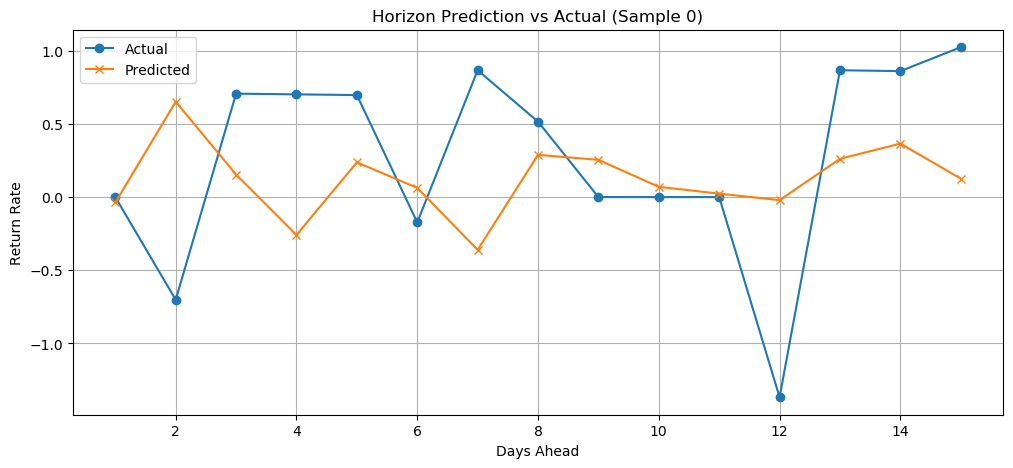

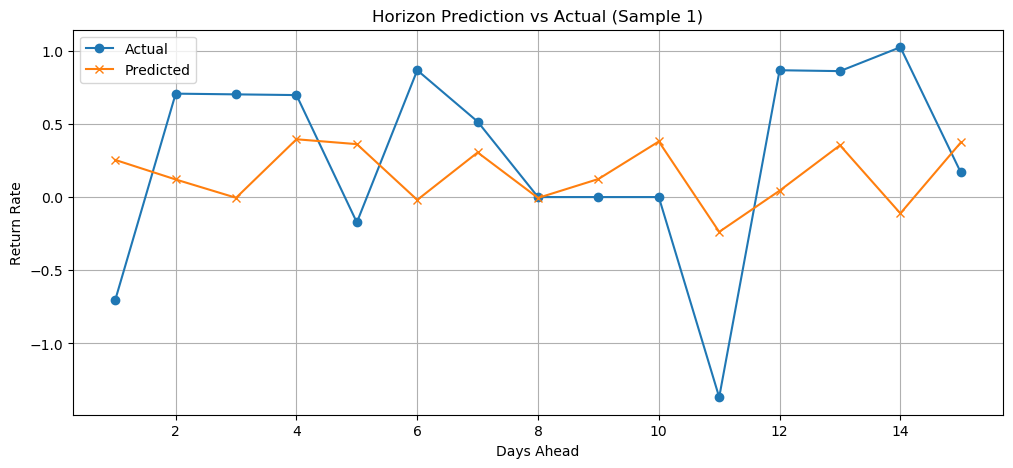

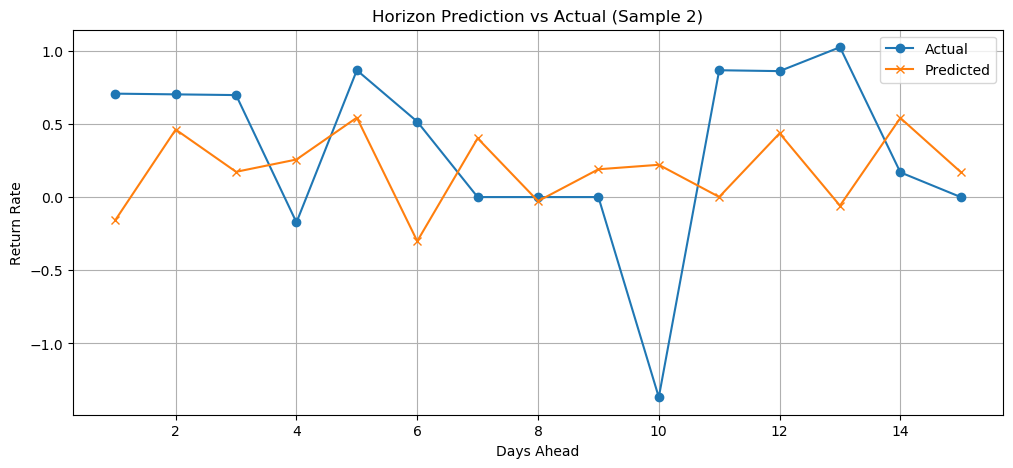

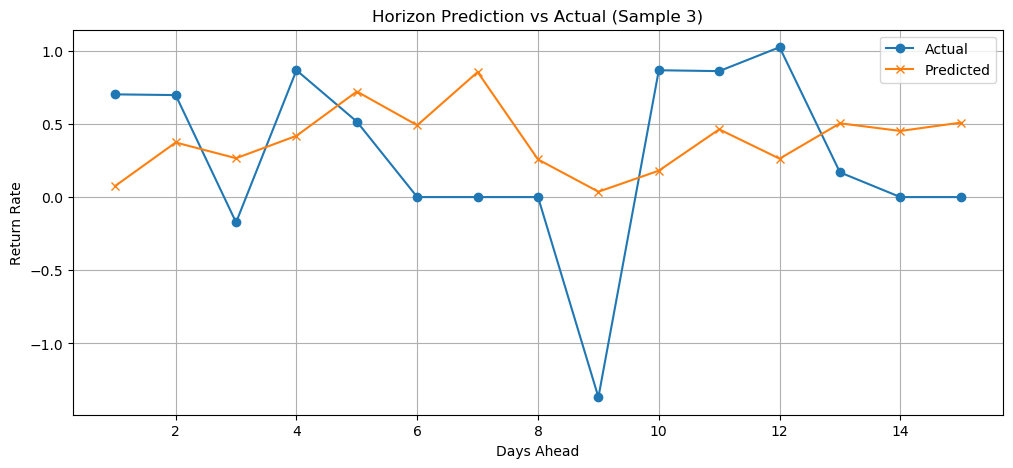

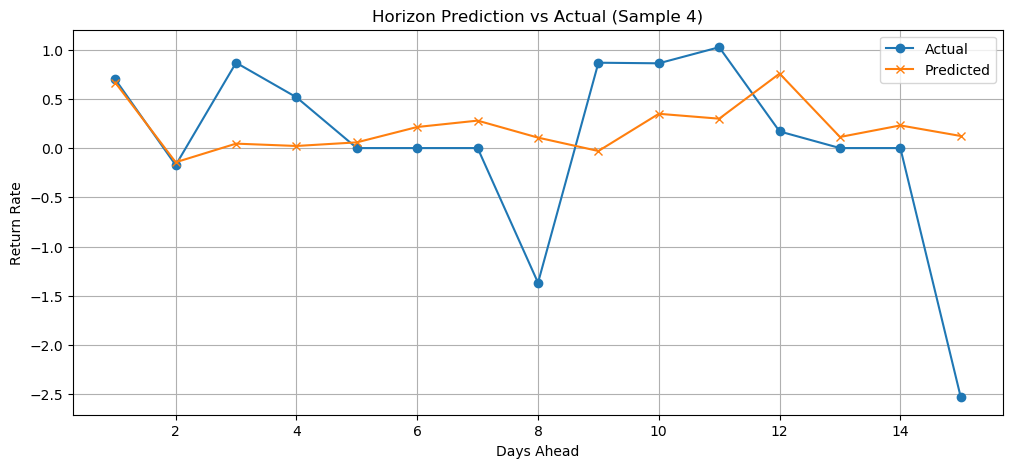

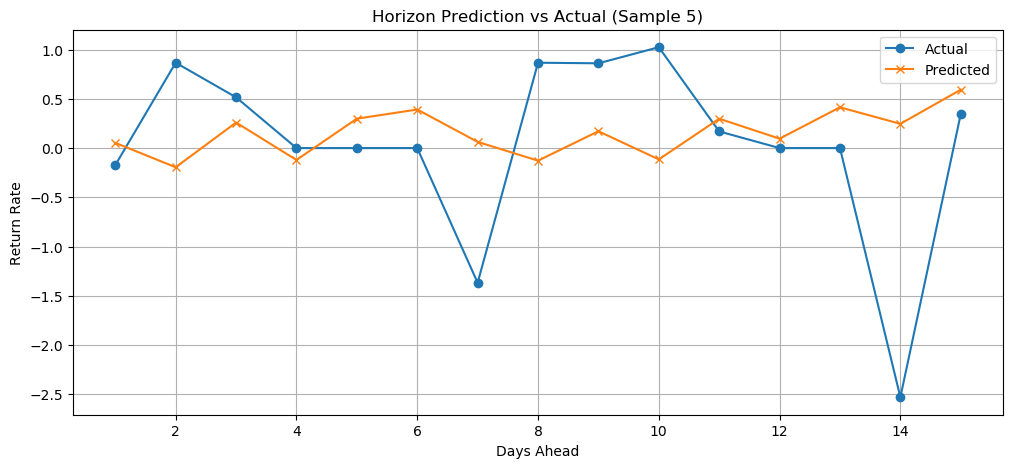

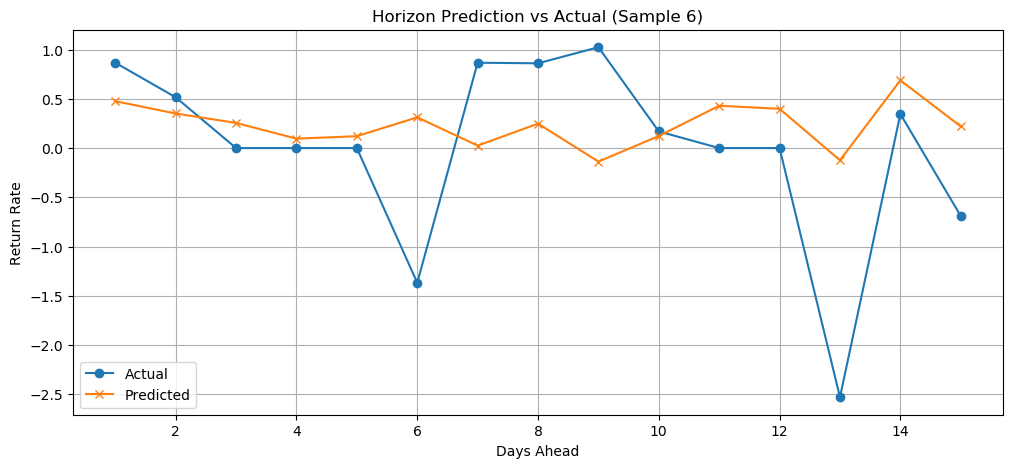

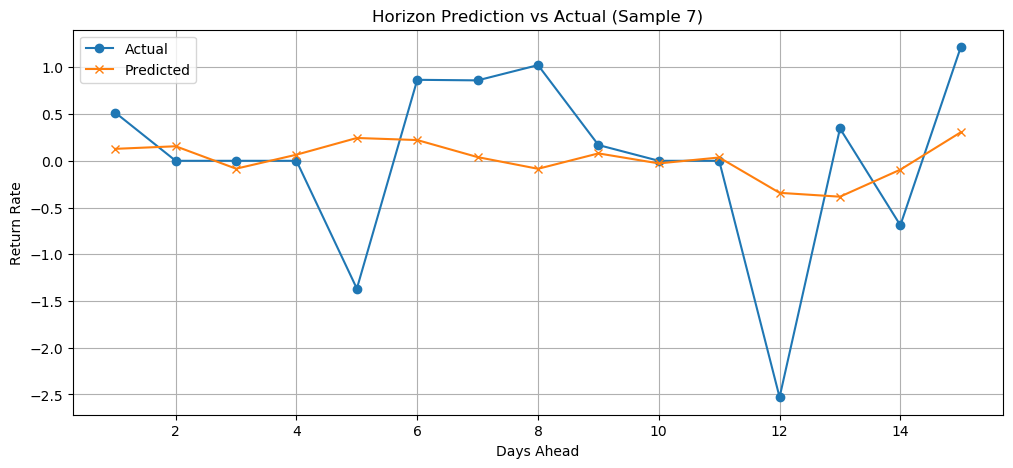

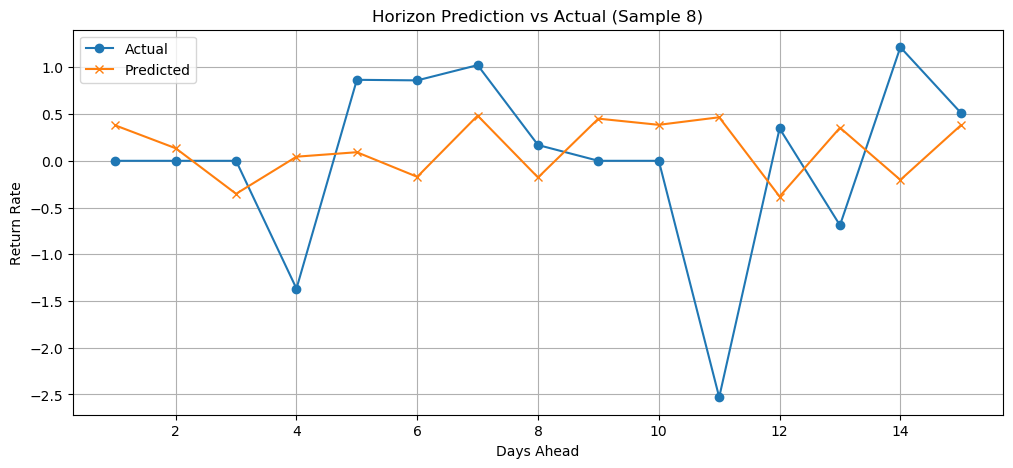

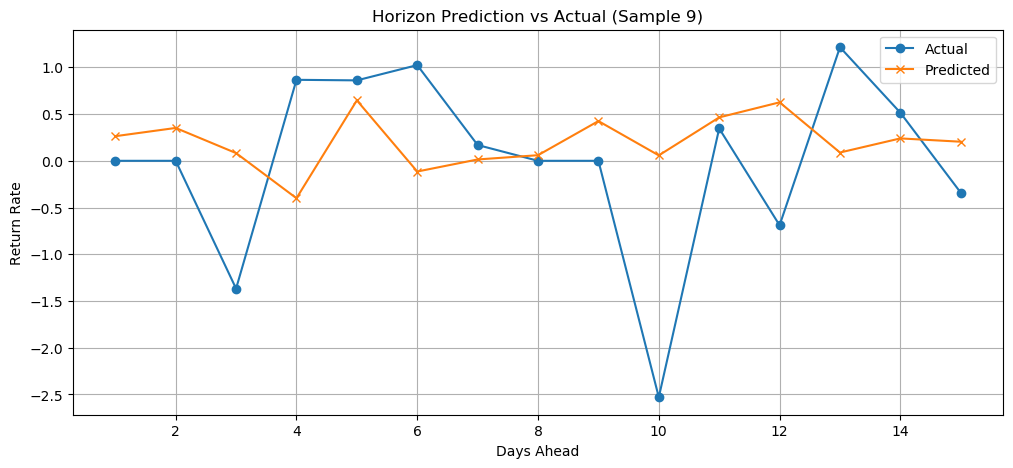

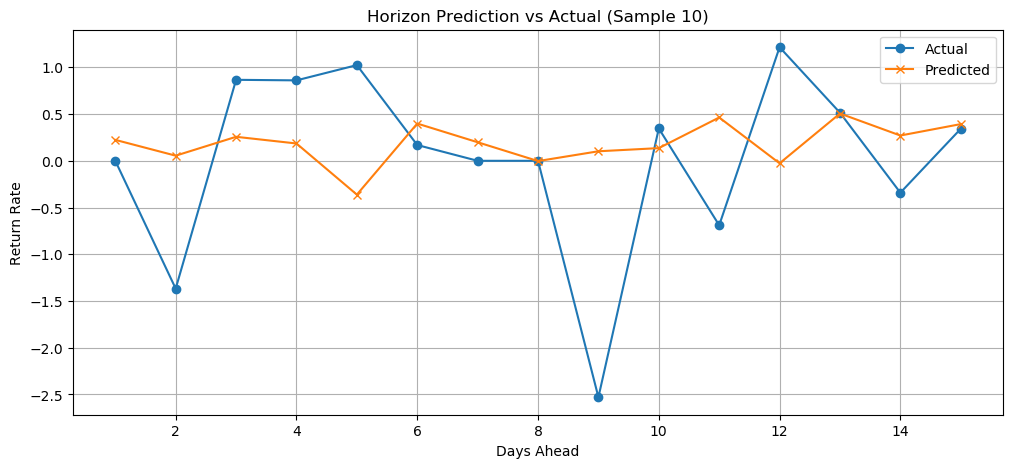

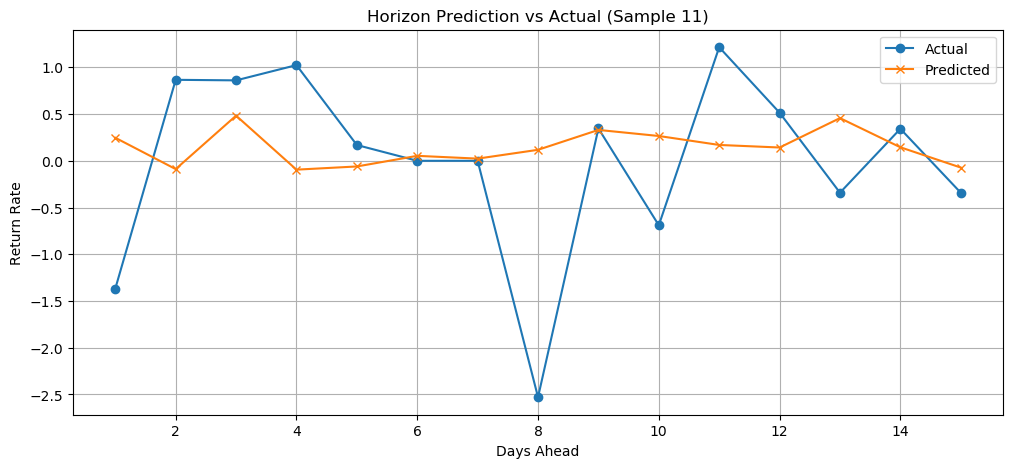

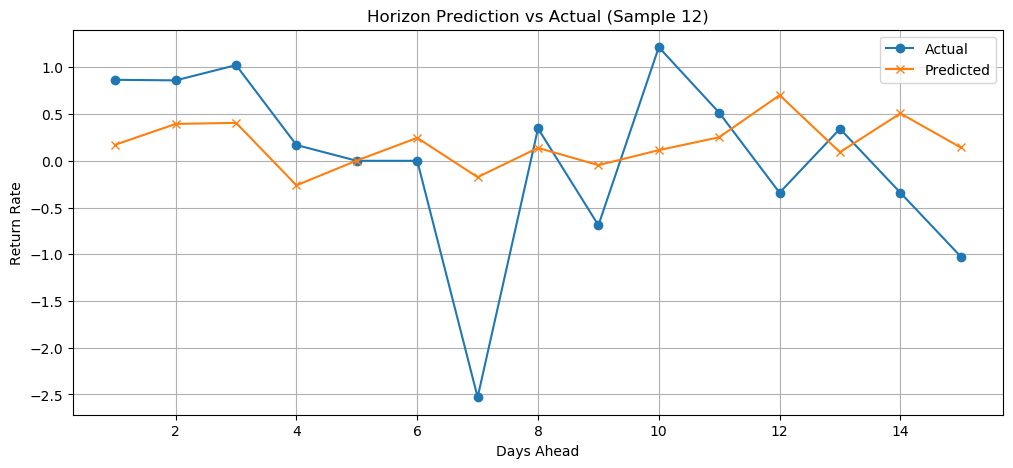

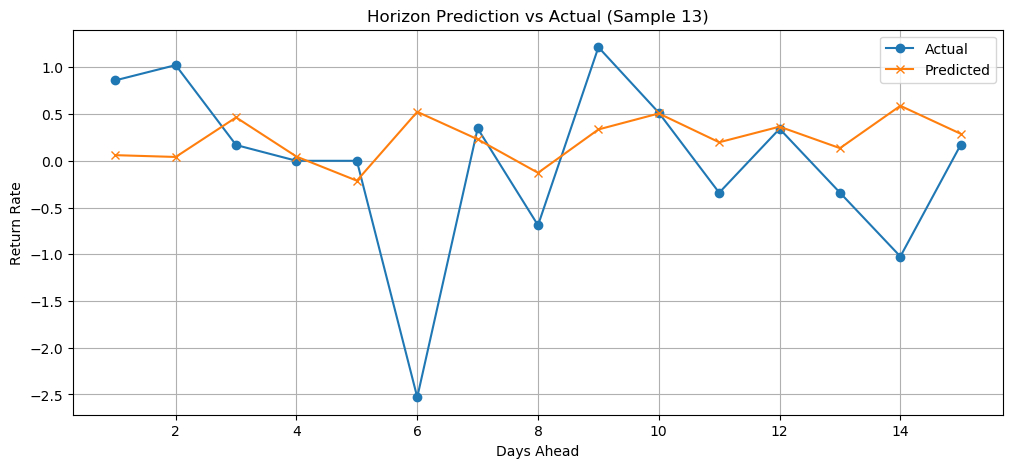

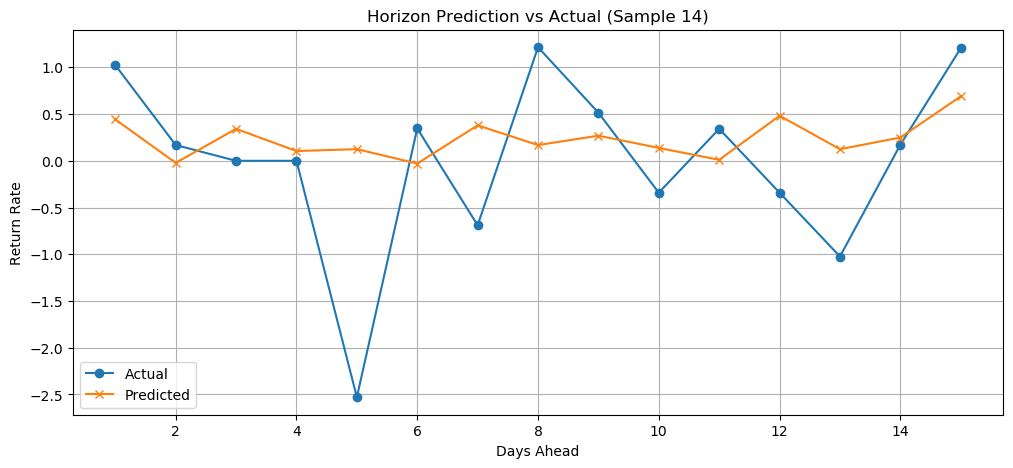

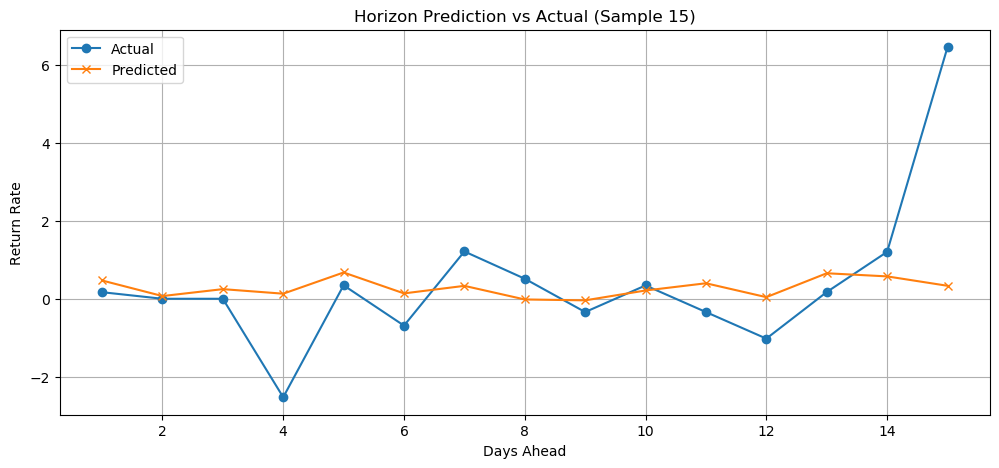

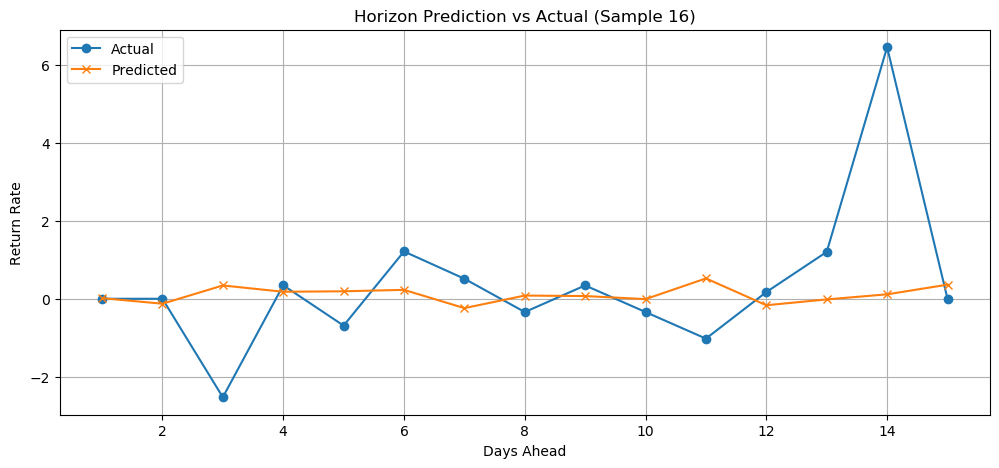

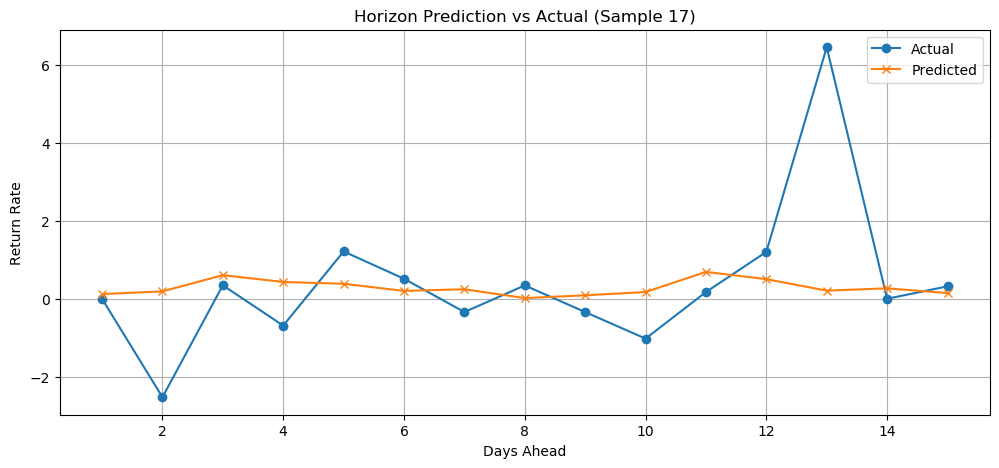

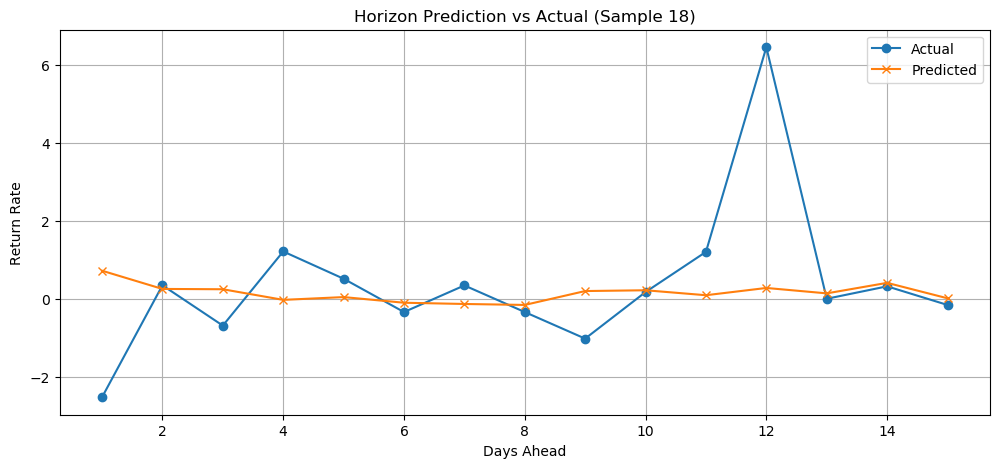

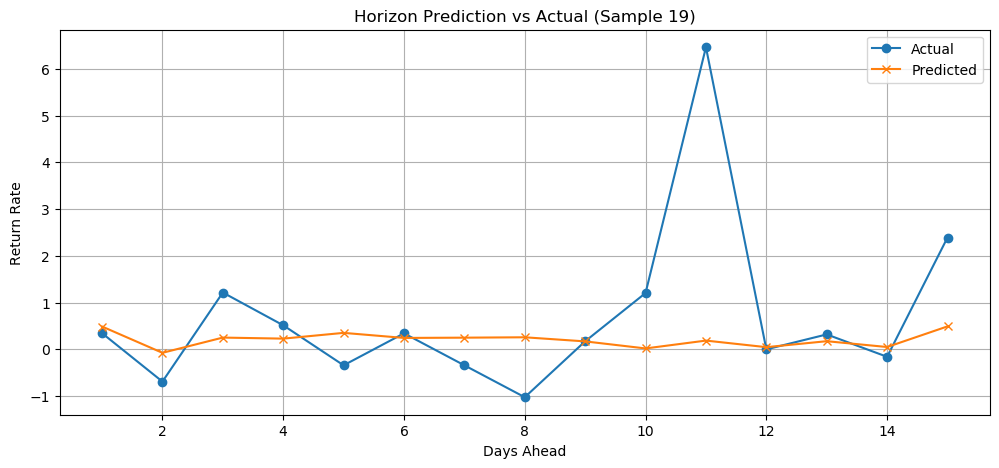

In [13]:
import matplotlib.pyplot as plt


for i in range(20):
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, testy.shape[1]+1), testy[i], label='Actual', marker='o')
    plt.plot(range(1, preds.shape[1]+1), preds[i], label='Predicted', marker='x')
    plt.title(f'Horizon Prediction vs Actual (Sample {i})')
    plt.xlabel('Days Ahead')
    plt.ylabel('Return Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
from sklearn.metrics import r2_score

for h in range(testy.shape[1]):  # horizon 0~9 對應第 1~10 天
    r2 = r2_score(testy[:, h], preds[:, h])
    print(f"Horizon {h+1}: R² = {r2:.4f}")


Horizon 1: R² = -0.0048
Horizon 2: R² = -0.0385
Horizon 3: R² = -0.0037
Horizon 4: R² = 0.0020
Horizon 5: R² = -0.0061
Horizon 6: R² = -0.0409
Horizon 7: R² = -0.0206
Horizon 8: R² = -0.0177
Horizon 9: R² = 0.0286
Horizon 10: R² = -0.0115
Horizon 11: R² = -0.0306
Horizon 12: R² = -0.0221
Horizon 13: R² = -0.0002
Horizon 14: R² = -0.0134
Horizon 15: R² = -0.0057


In [15]:
pred_up = preds[:, 1:] > preds[:, :-1]
true_up = testy[:, 1:] > testy[:, :-1]
direction_acc = (pred_up == true_up).mean()
print(f"Directional Accuracy: {direction_acc:.4f}")

Directional Accuracy: 0.5041


#### 訓練 (多層)

In [16]:
trainX_flat = trainX.reshape(trainX.shape[0], -1)  # [N, window × (features+2)]
testX_flat = testX.reshape(testX.shape[0], -1)

# 建立堆疊式 encoder，每層都是 NeuralNet 的 instance
layer1 = NeuralNet(num_nodes=128, classification=False)
layer2 = NeuralNet(num_nodes=128, classification=False)
layer3 = NeuralNet(num_nodes=128, classification=False)

# 依序訓練 encoder 層（可選 pre-train），例如你先用 autoencoder 或逐層微調
layer1.fit(trainX_flat, trainX_flat, dropout=True, maxiter=100)  # 自編碼 pretrain
A1 = layer1.hidden_activations(trainX_flat)
layer2.fit(A1, A1)
A2 = layer2.hidden_activations(A1)
layer3.fit(A2, A2)
A3 = layer3.hidden_activations(A2)

# 測試資料也一樣
A1_test = layer1.hidden_activations(testX_flat)
A2_test = layer2.hidden_activations(A1_test)
A3_test = layer3.hidden_activations(A2_test)


# 建立主網路並 fine-tune 全部
regressor = NeuralNet(num_nodes=256, classification=False, learn_rate=0.001)
regressor.fit(A3, trainy, dropout=True, maxiter=300)  # 不用帶入 layers
preds = regressor.predict(A3_test, proba=False).T



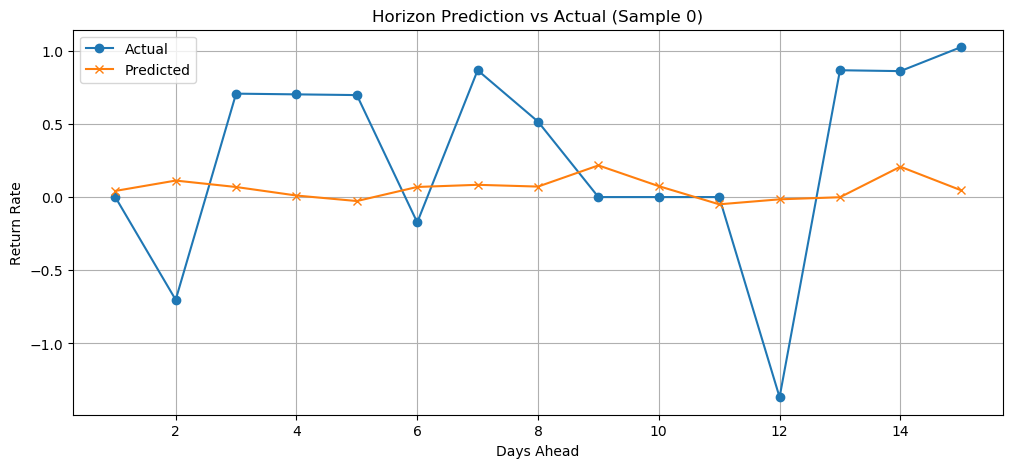

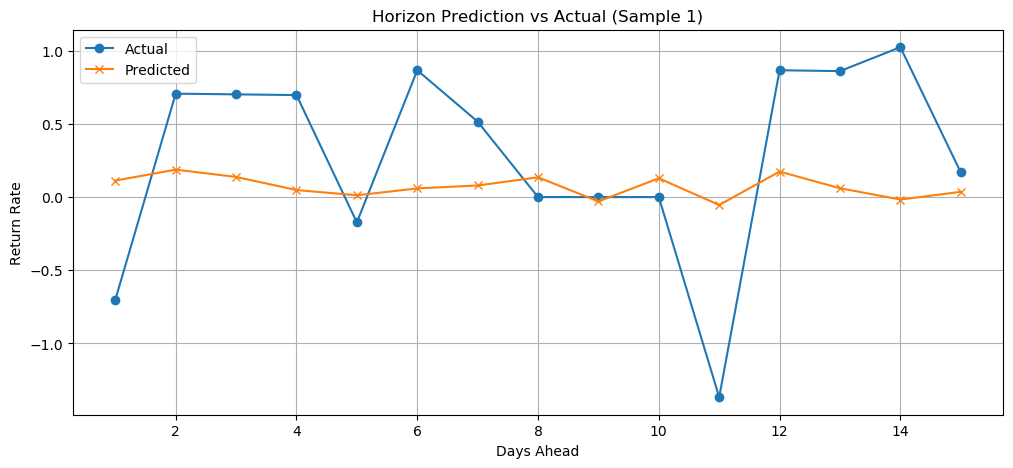

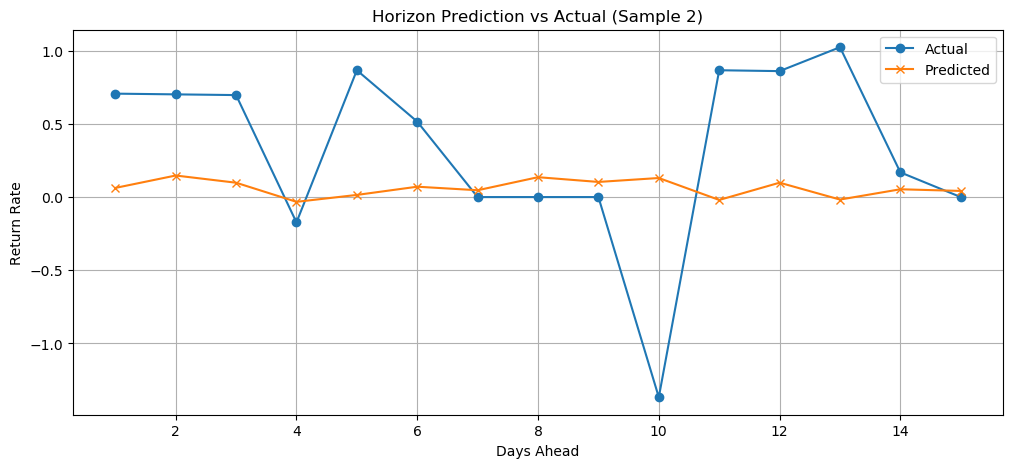

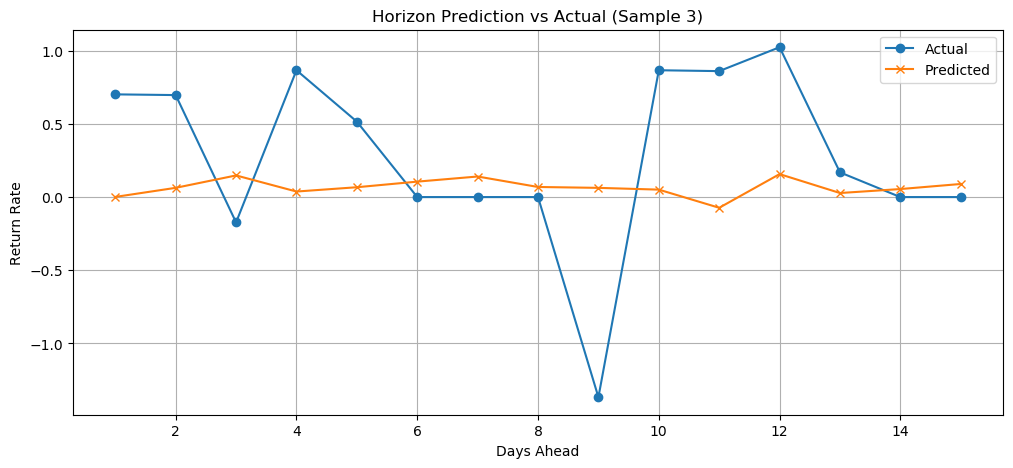

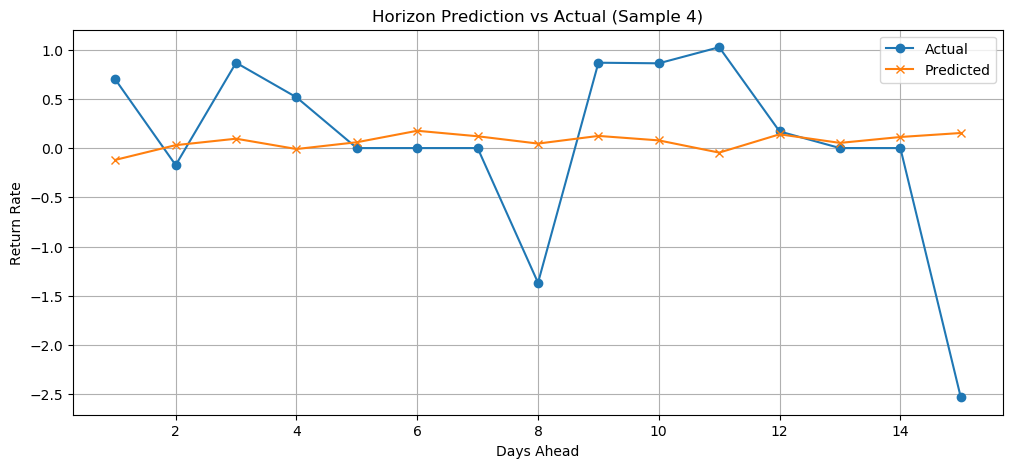

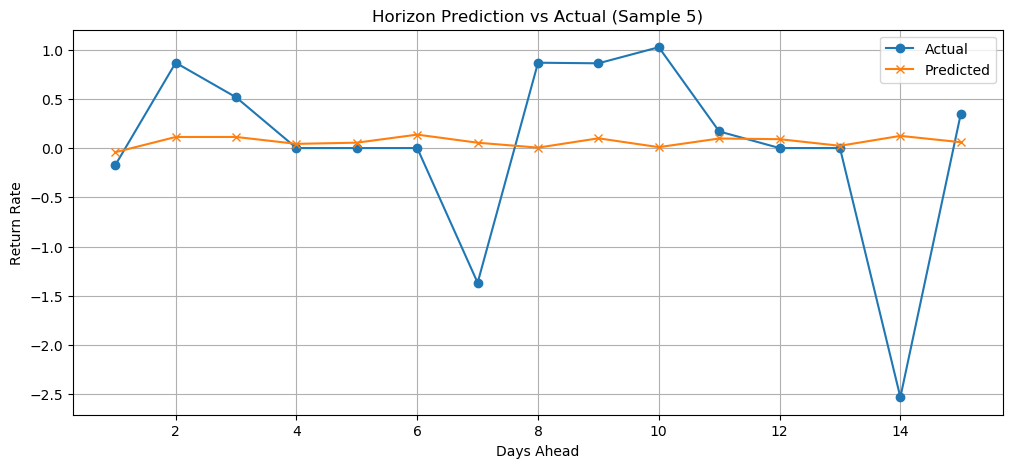

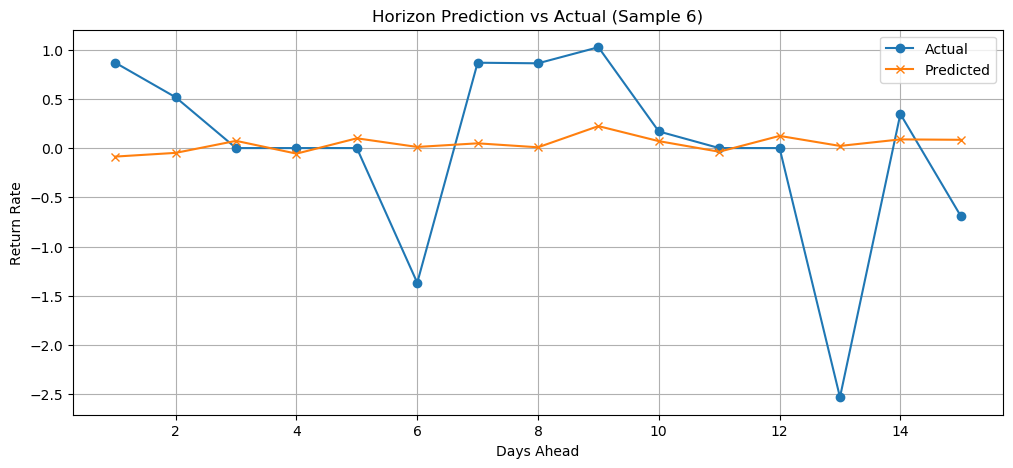

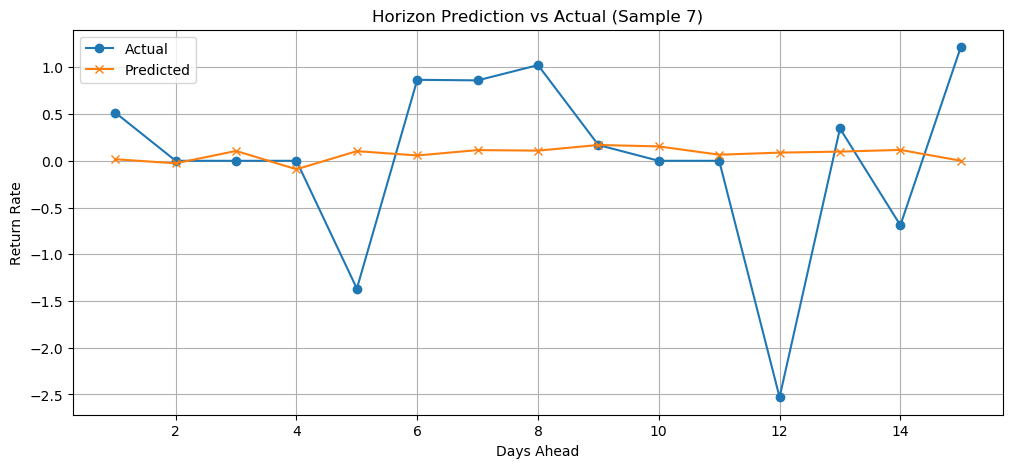

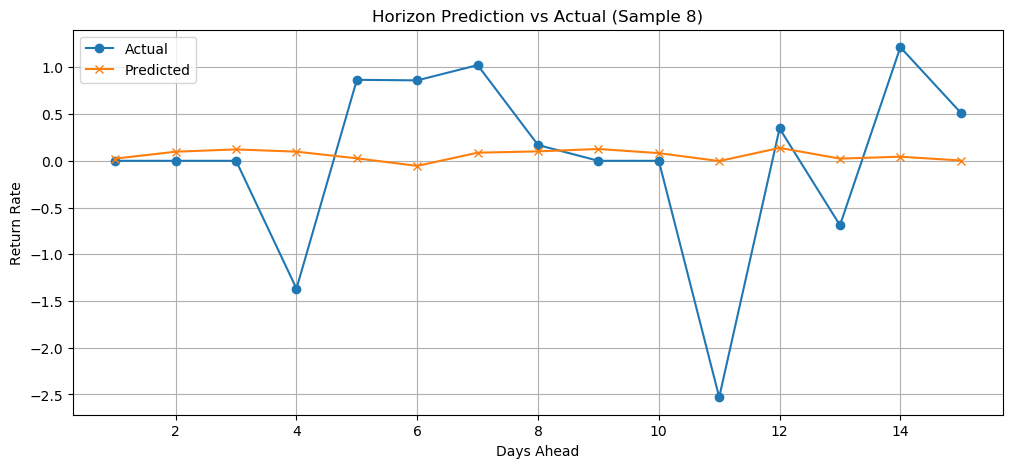

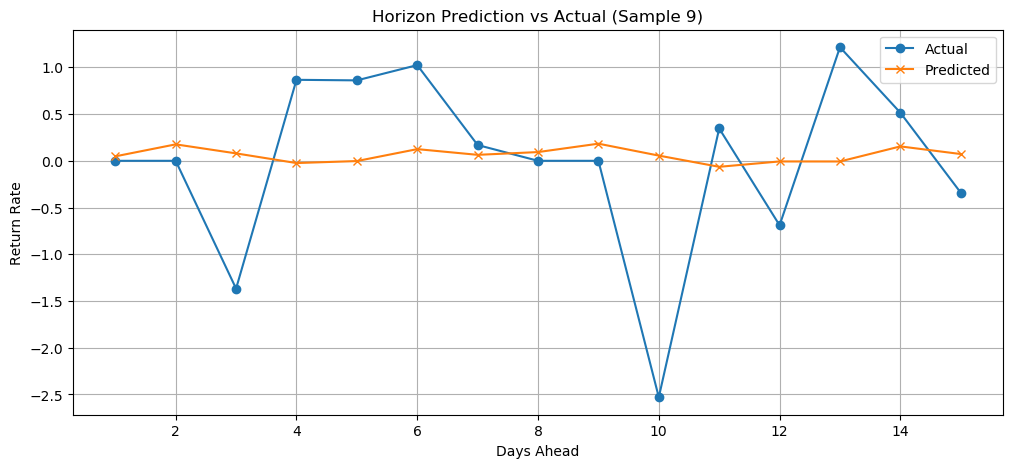

In [17]:
for i in range(10):
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, testy.shape[1]+1), testy[i], label='Actual', marker='o')
    plt.plot(range(1, preds.shape[1]+1), preds[i], label='Predicted', marker='x')
    plt.title(f'Horizon Prediction vs Actual (Sample {i})')
    plt.xlabel('Days Ahead')
    plt.ylabel('Return Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
trainX_flat = trainX.reshape(trainX.shape[0], -1)  # [N, window × (features+2)]
testX_flat = testX.reshape(testX.shape[0], -1)

# 建立堆疊式 encoder，每層都是 NeuralNet 的 instance
layer1 = NeuralNet(num_nodes=16, classification=False)
layer2 = NeuralNet(num_nodes=54, classification=False)

# 依序訓練 encoder 層（可選 pre-train），例如你先用 autoencoder 或逐層微調
layer1.fit(trainX_flat, trainX_flat, dropout=True, maxiter=100)  # 自編碼 pretrain
A1 = layer1.hidden_activations(trainX_flat)
layer2.fit(A1, A1)
A2 = layer2.hidden_activations(A1)


# 測試資料也一樣
A1_test = layer1.hidden_activations(testX_flat)
A2_test = layer2.hidden_activations(A1_test)



# 建立主網路並 fine-tune 全部
regressor = NeuralNet(num_nodes=256, classification=False, learn_rate=0.001)
regressor.fit(A2, trainy, dropout=True, maxiter=300)  # 不用帶入 layers
preds = regressor.predict(A2_test, proba=False).T

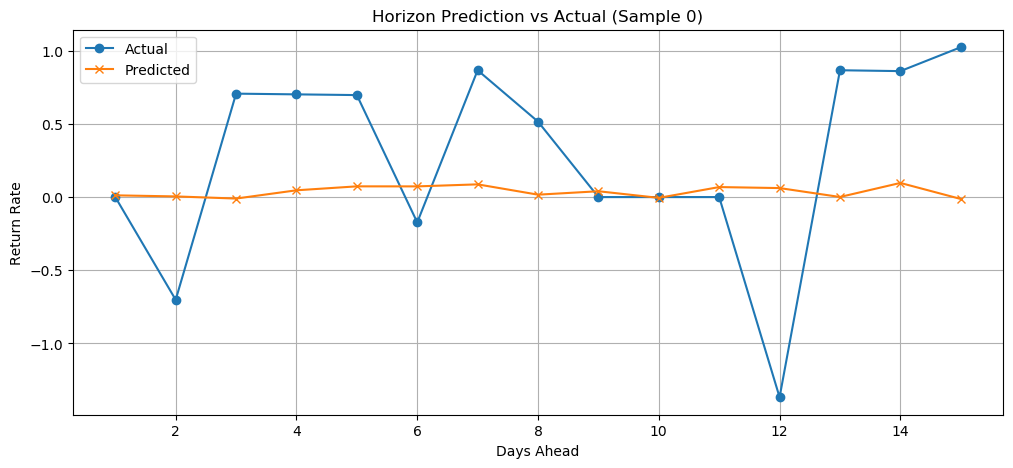

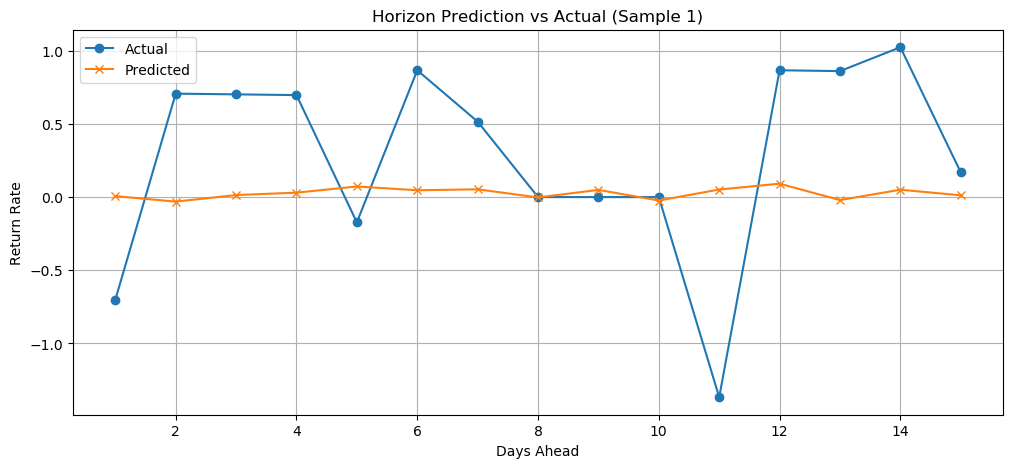

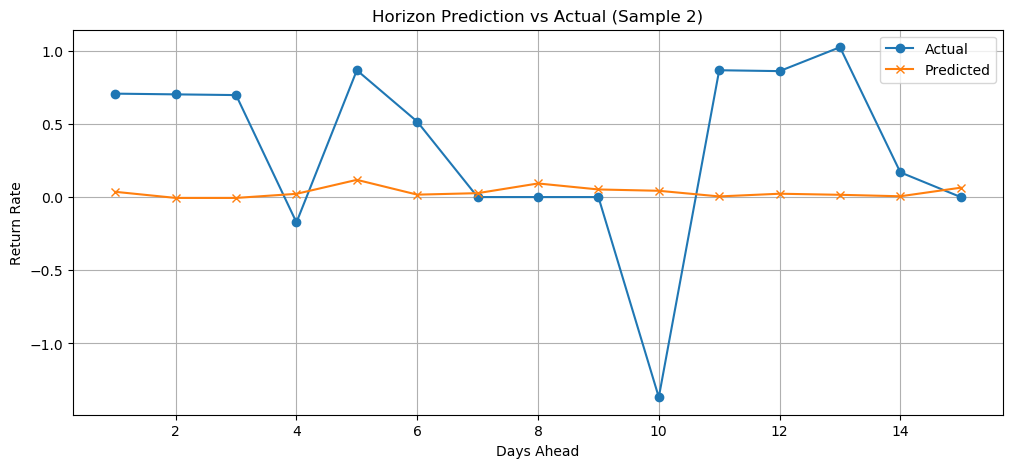

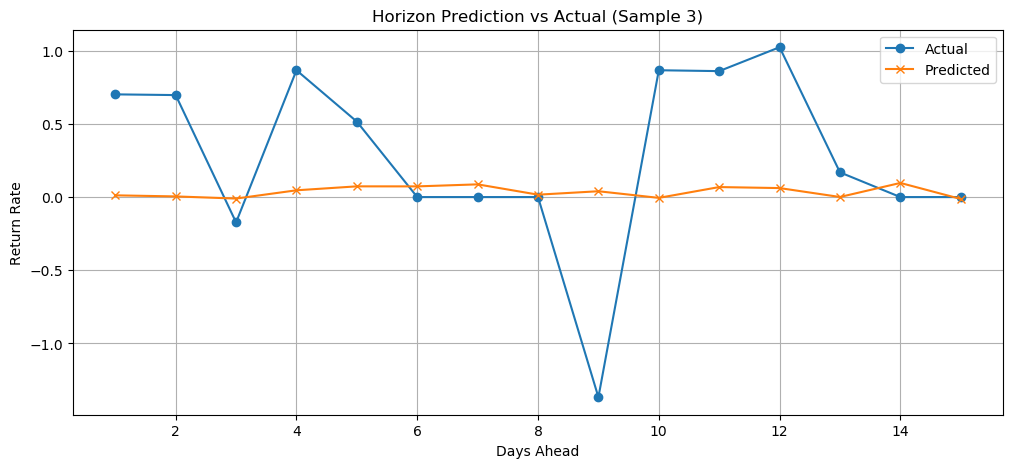

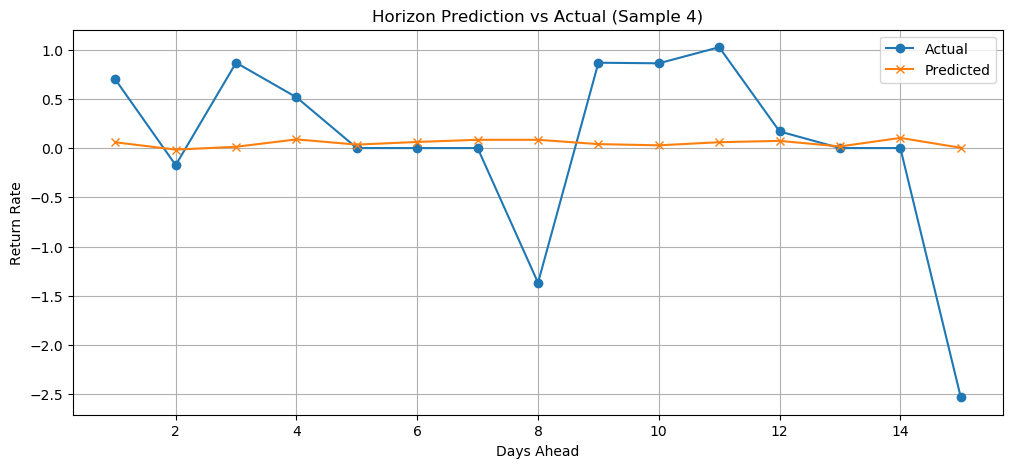

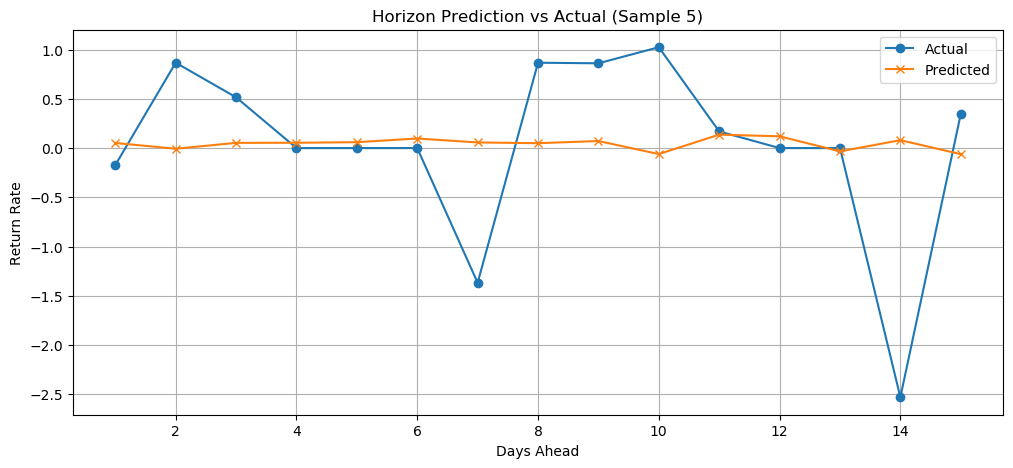

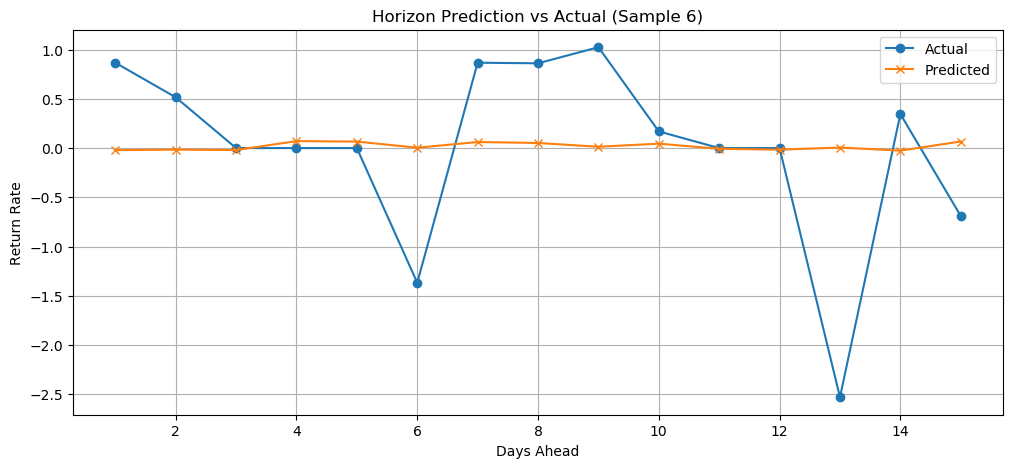

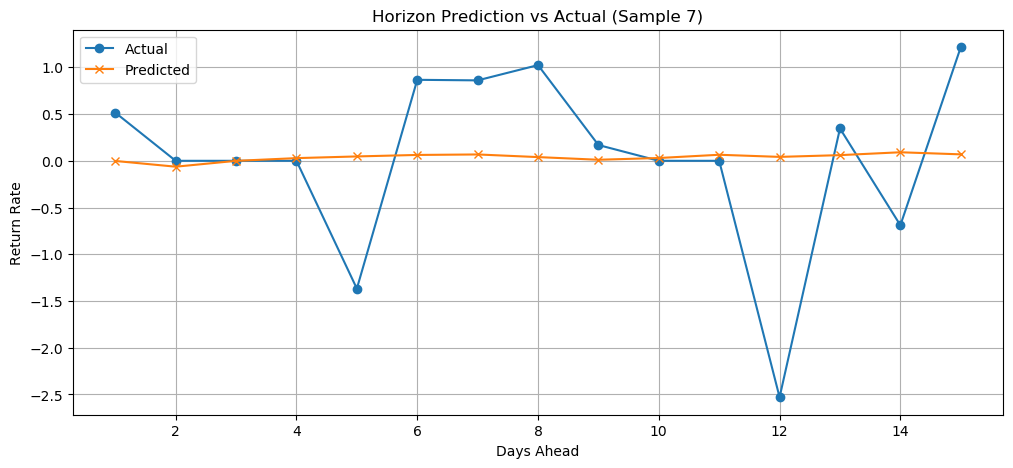

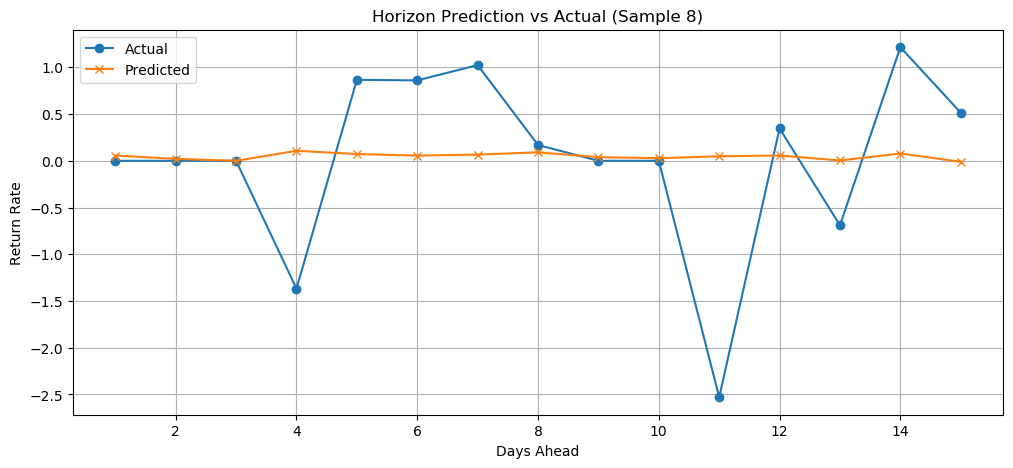

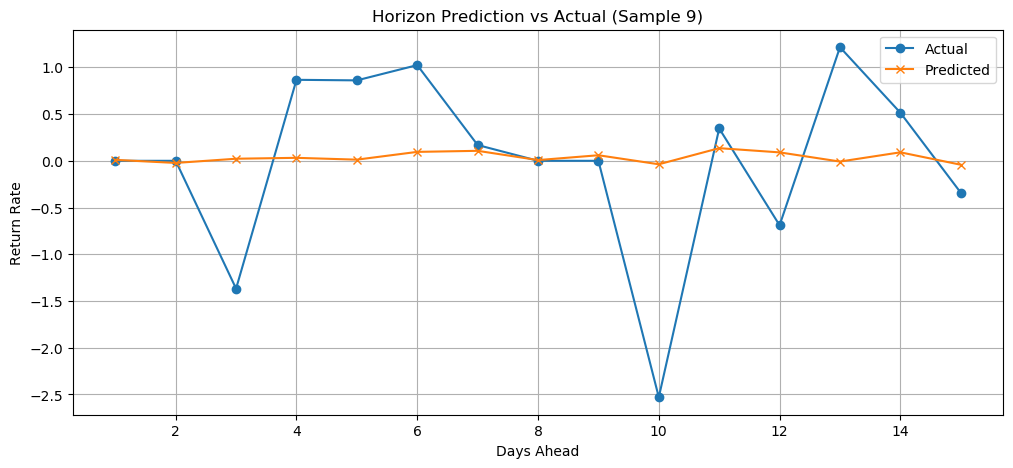

In [19]:
for i in range(10):
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, testy.shape[1]+1), testy[i], label='Actual', marker='o')
    plt.plot(range(1, preds.shape[1]+1), preds[i], label='Predicted', marker='x')
    plt.title(f'Horizon Prediction vs Actual (Sample {i})')
    plt.xlabel('Days Ahead')
    plt.ylabel('Return Rate')
    plt.legend()
    plt.grid(True)
    plt.show()